In [4]:
%pip install torch torchvision torchaudio --quiet
%pip install scikit-learn matplotlib seaborn tqdm --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Brain Tumor Classification with ResNet-18 and VGG16
---
## 1. Dataset Selection
We use a brain tumor image dataset containing four classes: glioma_tumor, meningioma_tumor, no_tumor, and pituitary_tumor. This dataset is suitable for multi-class classification and provides a real-world medical imaging challenge. The diversity of tumor types allows us to evaluate the effectiveness of deep learning models in distinguishing between different brain tumor categories as well as healthy cases.

## 2. Preprocessing
All images are resized to 224x224 pixels to match the input requirements of pretrained models. For training, we apply data augmentation (random crops, flips, rotations, color jitter) to improve generalization. For validation, we use resizing and centercrop. All images are normalized using ImageNet statistics to match the pretrained model expectations.

## 3. Model Fine-Tuning
We use two pretrained models: ResNet-18 and VGG16. The final fully connected layers are replaced to match the number of classes in our dataset. We use feature extraction (freezing most layers) but allow the final layer to be trained. Optionally, more layers can be unfrozen for further fine-tuning if desired.

## 4. Model Evaluation
Models are evaluated using accuracy, precision, recall, F1-score, and confusion matrix. These metrics provide a comprehensive view of model performance, especially for imbalanced or multi-class problems. Visualizations include training/validation loss and accuracy curves, as well as confusion matrices for each model.

## 5. Model Comparison and Discussion
We compare the performance of ResNet-18 and VGG16 in terms of accuracy, speed, and generalization. ResNet-18 is typically faster and less prone to overfitting due to its residual connections, while VGG16 may achieve higher accuracy at the cost of increased computation. The results and trade-offs are discussed based on the evaluation metrics and visualizations.

In [6]:
%pip install --upgrade pip

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----------------------------------- ---- 1.6/1.8 MB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 4.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install -q torch torchvision scikit-learn matplotlib seaborn tqdm


In [2]:
# 2. Imports
import os
import time
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [3]:
# 3. Set dataset path
DATA_DIR = "C:/Users/Syeda Aiman Mumtaz/Documents/GIKI BOOTCAMP/week2tasks/tumordata"  # Corrected dataset root path

# 4. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 5. Hyperparameters
NUM_EPOCHS = 11
BATCH_SIZE = 32
IMG_SIZE = 224
LR = 1e-4

Using device: cpu


In [4]:
# Data augmentations for training and validation
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(int(IMG_SIZE * 1.14)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Load dataset with folder structure: root/class_x/img.jpg
train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'Training'), transform=data_transforms['Training'])
# We'll split train_dataset into train/val below
num_classes = len(train_dataset.classes)
print("Classes found:", train_dataset.classes)


Classes found: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [6]:
# Split dataset into train and validation (80% train, 20% val)
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Assign validation transforms to validation dataset
val_subset.dataset.transform = data_transforms['Testing']

# DataLoaders for batching (set num_workers=0 for Windows compatibility)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': train_size, 'val': val_size}
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [7]:
def get_resnet18(num_classes, feature_extract=True):
    model = models.resnet18(pretrained=True)
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(device)

def get_vgg16(num_classes, feature_extract=True):
    model = models.vgg16(pretrained=True)
    if feature_extract:
        for param in model.features.parameters():
            param.requires_grad = False
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
    return model.to(device)

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_hist.append(epoch_loss)
                train_acc_hist.append(epoch_acc.item())
            else:
                val_loss_hist.append(epoch_loss)
                val_acc_hist.append(epoch_acc.item())

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val accuracy: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_hist, 'val_loss': val_loss_hist,
        'train_acc': train_acc_hist, 'val_acc': val_acc_hist
    }
    return model, history


In [9]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    class_names = train_dataset.classes

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    return acc, precision, recall, f1


Training ResNet-18...


c:\Users\Syeda Aiman Mumtaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Syeda Aiman Mumtaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/11
--------------------


  0%|          | 0/72 [00:00<?, ?it/s]c:\Users\Syeda Aiman Mumtaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Syeda Aiman Mumtaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                                               

train Loss: 1.2924  Acc: 0.3606


val Loss: 1.2016  Acc: 0.4861

Epoch 2/11
--------------------


train Loss: 1.1367  Acc: 0.5266


val Loss: 1.0651  Acc: 0.5976

Epoch 3/11
--------------------


train Loss: 1.0204  Acc: 0.6254


val Loss: 0.9612  Acc: 0.6655

Epoch 4/11
--------------------


train Loss: 0.9382  Acc: 0.6651


val Loss: 0.8801  Acc: 0.7213

Epoch 5/11
--------------------


train Loss: 0.8666  Acc: 0.7060


val Loss: 0.8152  Acc: 0.7509

Epoch 6/11
--------------------


train Loss: 0.8128  Acc: 0.7274


val Loss: 0.7657  Acc: 0.7613

Epoch 7/11
--------------------


train Loss: 0.7688  Acc: 0.7409


val Loss: 0.7209  Acc: 0.7700

Epoch 8/11
--------------------


train Loss: 0.7522  Acc: 0.7526


val Loss: 0.7185  Acc: 0.7700

Epoch 9/11
--------------------


train Loss: 0.7417  Acc: 0.7487


val Loss: 0.7130  Acc: 0.7770

Epoch 10/11
--------------------


train Loss: 0.7385  Acc: 0.7530


val Loss: 0.7099  Acc: 0.7805

Epoch 11/11
--------------------


train Loss: 0.7343  Acc: 0.7552


val Loss: 0.7058  Acc: 0.7840

Training complete in 35m 52s
Best val accuracy: 0.7840

Evaluating ResNet-18...


100%|██████████| 18/18 [00:35<00:00,  1.96s/it]



Accuracy: 0.7840
Precision: 0.7831
Recall: 0.7840
F1 Score: 0.7818

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.84      0.80      0.82       164
meningioma_tumor       0.67      0.65      0.66       149
        no_tumor       0.81      0.70      0.75        83
 pituitary_tumor       0.82      0.92      0.87       178

        accuracy                           0.78       574
       macro avg       0.78      0.77      0.77       574
    weighted avg       0.78      0.78      0.78       574



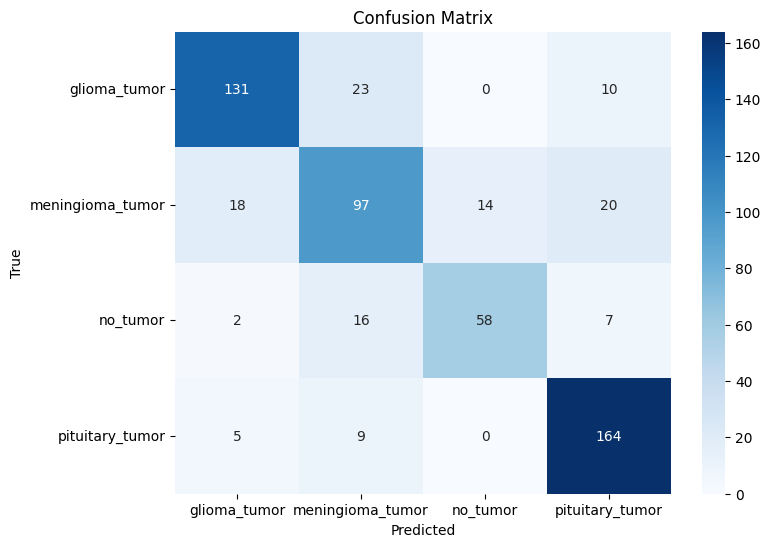

(0.7839721254355401,
 0.7830814507731646,
 0.7839721254355401,
 0.7818089726953109)

In [10]:
print("\nTraining ResNet-18...")
resnet_model = get_resnet18(num_classes=num_classes, feature_extract=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=LR)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnet_model, resnet_history = train_model(resnet_model, criterion, optimizer, scheduler)

print("\nEvaluating ResNet-18...")
evaluate_model(resnet_model, val_loader)



Training VGG16...


c:\Users\Syeda Aiman Mumtaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Syeda Aiman Mumtaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Syeda Aiman Mumtaz/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [01:33<00:00, 5.92MB/s] 




Epoch 1/11
--------------------


  0%|          | 0/72 [00:00<?, ?it/s]c:\Users\Syeda Aiman Mumtaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Syeda Aiman Mumtaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                                               

train Loss: 0.6082  Acc: 0.7496


val Loss: 0.2851  Acc: 0.8990

Epoch 2/11
--------------------


train Loss: 0.2246  Acc: 0.9133


val Loss: 0.2134  Acc: 0.9268

Epoch 3/11
--------------------


train Loss: 0.1050  Acc: 0.9625


val Loss: 0.2326  Acc: 0.9164

Epoch 4/11
--------------------


train Loss: 0.0566  Acc: 0.9743


val Loss: 0.1708  Acc: 0.9460

Epoch 5/11
--------------------

Epoch 5/11
--------------------


train Loss: 0.0307  Acc: 0.9900


val Loss: 0.2109  Acc: 0.9373

Epoch 6/11
--------------------


train Loss: 0.0281  Acc: 0.9913


val Loss: 0.1785  Acc: 0.9530

Epoch 7/11
--------------------


train Loss: 0.0310  Acc: 0.9887


val Loss: 0.1695  Acc: 0.9390

Epoch 8/11
--------------------


train Loss: 0.0087  Acc: 0.9974


val Loss: 0.1305  Acc: 0.9582

Epoch 9/11
--------------------


train Loss: 0.0042  Acc: 1.0000


val Loss: 0.1155  Acc: 0.9634

Epoch 10/11
--------------------


train Loss: 0.0048  Acc: 0.9987


val Loss: 0.1204  Acc: 0.9669

Epoch 11/11
--------------------


train Loss: 0.0026  Acc: 0.9996


val Loss: 0.1249  Acc: 0.9634

Training complete in 180m 7s
Best val accuracy: 0.9669

Evaluating VGG16...


100%|██████████| 18/18 [03:00<00:00, 10.01s/it]



Accuracy: 0.9669
Precision: 0.9680
Recall: 0.9669
F1 Score: 0.9670

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.93      0.96       164
meningioma_tumor       0.92      0.97      0.94       149
        no_tumor       0.98      0.99      0.98        83
 pituitary_tumor       0.98      0.99      0.99       178

        accuracy                           0.97       574
       macro avg       0.97      0.97      0.97       574
    weighted avg       0.97      0.97      0.97       574



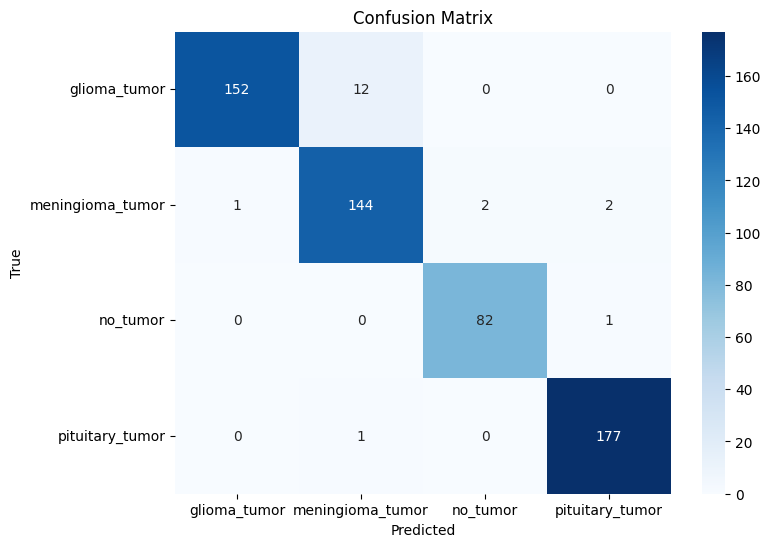

(0.9668989547038328,
 0.9680272958440275,
 0.9668989547038328,
 0.9669510405704871)

In [11]:
print("\nTraining VGG16...")
vgg_model = get_vgg16(num_classes=num_classes, feature_extract=True)
optimizer_vgg = optim.Adam(filter(lambda p: p.requires_grad, vgg_model.parameters()), lr=LR)
scheduler_vgg = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

vgg_model, vgg_history = train_model(vgg_model, criterion, optimizer_vgg, scheduler_vgg)

print("\nEvaluating VGG16...")
evaluate_model(vgg_model, val_loader)



Plotting training curves...


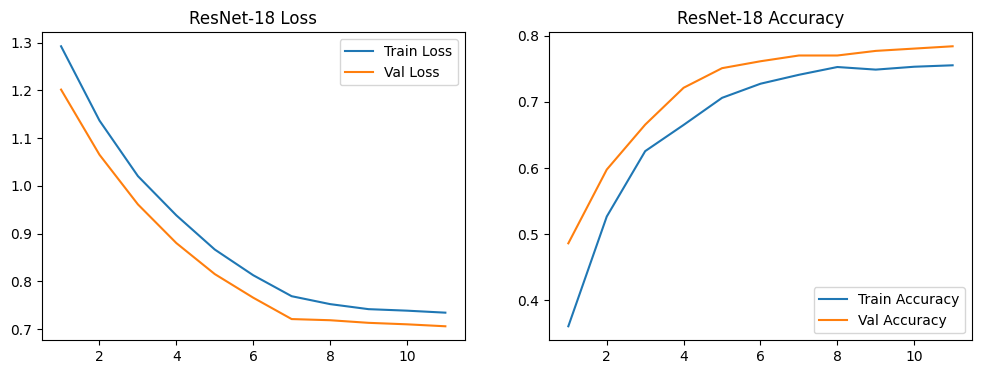

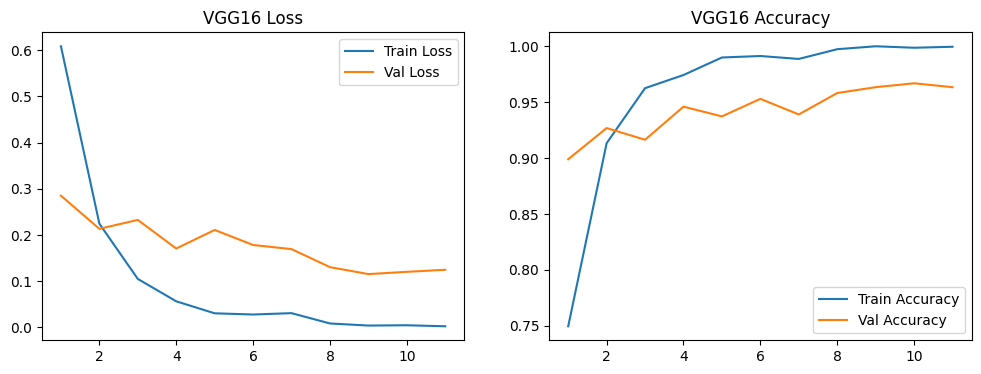

In [12]:
def plot_training_curves(history, title="Training Curves"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.show()

print("\nPlotting training curves...")
plot_training_curves(resnet_history, "ResNet-18")
plot_training_curves(vgg_history, "VGG16")


c:\Users\Syeda Aiman Mumtaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


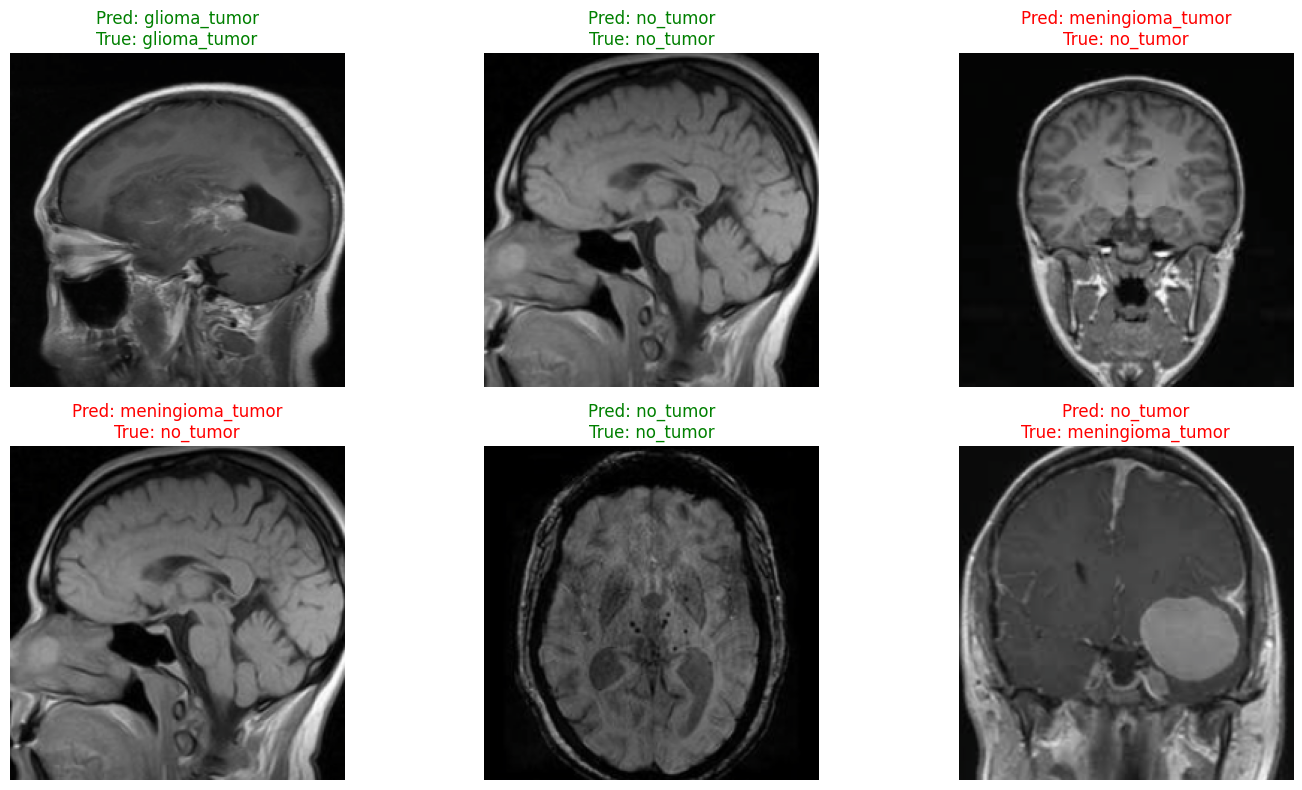

In [13]:
# Visualize predictions on validation set
import random
def visualize_predictions(model, dataloader, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 8))
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                inp = inputs[j].cpu().numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                plt.imshow(inp)
                pred_label = class_names[preds[j]]
                true_label = class_names[labels[j]]
                color = 'green' if pred_label == true_label else 'red'
                plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
                plt.axis('off')
                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return

# Example: Visualize predictions for ResNet-18
visualize_predictions(resnet_model, val_loader, train_dataset.classes, num_images=6)

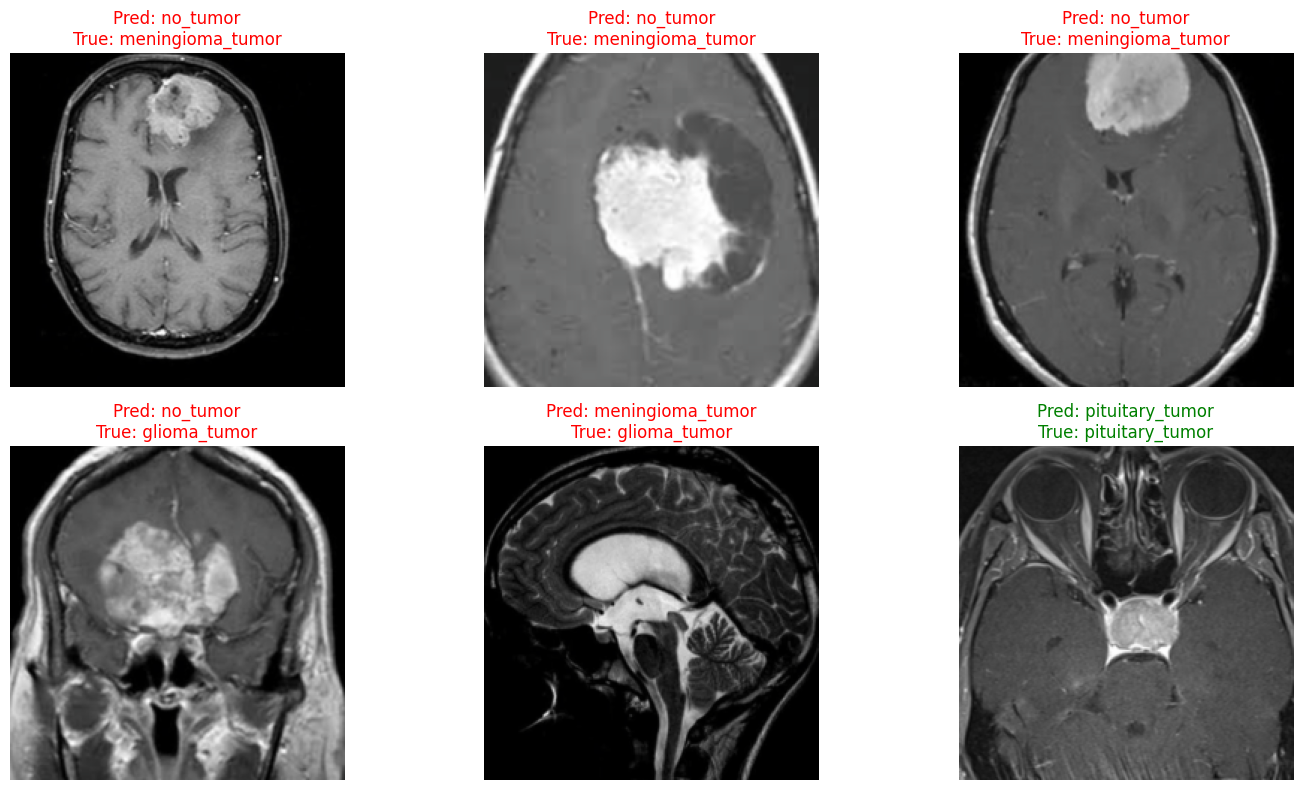

In [14]:
# Create test dataset and loader from Testing folder
test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'Testing'), transform=data_transforms['Testing'])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

# Visualize predictions for ResNet-18 on test set
visualize_predictions(resnet_model, test_loader, test_dataset.classes, num_images=6)